In [ ]:
# RiskRadar Global Flood Prediction System (Enhanced Validation Edition)
# Install dependencies
!pip install xgboost folium imbalanced-learn kagglehub tqdm -q
!google-colab.output.enable_custom_widget_manager()

import numpy as np
import pandas as pd
import xgboost as xgb
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay)
from imblearn.over_sampling import SMOTE
from folium.plugins import MarkerCluster, HeatMap
from tqdm import tqdm
from sklearn.calibration import calibration_curve

/bin/bash: -c: line 2: syntax error: unexpected end of file


In [ ]:
# ======================
# 1. Enhanced Data Loading & Validation
# ======================
print("Loading dataset...")
df = pd.read_csv('/content/kuntla_flooddatabase.csv')

# Clean column names with validation
original_columns = set(df.columns)
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
print(f"Renamed columns: {set(original_columns) - set(df.columns)}")

# Null handling with dynamic threshold
null_threshold = len(df) * 0.4
initial_features = df.columns.tolist()
df = df.dropna(thresh=null_threshold, axis=1)
removed_features = set(initial_features) - set(df.columns)
print(f"Removed features due to nulls: {removed_features}")

# Validate required features
required_features = [
    'annual_peak_discharge', 'annual_precipitation',
    'precipitation_of_wettest_month', 'precipitation_seasonality',
    'drainage_density', 'drainage_texture', 'basin_relief'
]
missing_features = set(required_features) - set(df.columns)
if missing_features:
    raise ValueError(f"Critical features missing: {missing_features}")

# Fill numerical nulls
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Create target variable with validation
discharge_threshold = df['annual_peak_discharge'].quantile(0.95)
df['risk'] = np.where(df['annual_peak_discharge'] >= discharge_threshold, 1, 0)
print(f"Class balance: {df['risk'].value_counts(normalize=True).to_dict()}")


Loading dataset...
Renamed columns: {'Weighted Mean Bifurcationratio', 'Soil Type', 'FourthFifth Streamlengthratio', 'Sixthorder Mean Streamlength', 'FourthFifth Bifurcationratio', 'ThirdForth Bifurcationratio', 'Precipitation Seasonality', 'Firstorder Streamlength', 'Precipitation of Driest Quarter', 'Max Temperature of Warmest Month', 'FifthSixth Bifurcationratio', 'Drainage Intensity', 'Downvalley Length', 'SecondThird Bifurcationratio', 'Compactness Coefficient', 'Isothermality', 'Basin Perimeter', 'Drainage Texture', 'Number of Dams', 'Wandering Ratio', 'Length of Overland Flow', 'Drainage Area', 'SecondThird Streamlengthratio', 'Thirdorder Streamnumber', 'Stream Order', 'Seventhorder Streamnumber', 'Sixthseventh StreamLengthratio', 'Secondorder Mean Streamlength', 'Annual peak discharge', 'Mean Diurnal Range', 'Lithology Type', 'Fourthorder Streamnumber', 'Channel Frequency', 'Basin Length', 'Elongation Ratio', 'Fifthorder Streamnumber', 'Firstorder Mean Streamlength', 'FirstSeco

In [ ]:
# ======================
# 2. Secure Feature Engineering
# ======================
# Encode categorical features with validation
cat_cols = ['climate_type', 'landcover_type', 'soil_type', 'lithology_type']
missing_cats = set(cat_cols) - set(df.columns)
if missing_cats:
    raise ValueError(f"Missing categorical features: {missing_cats}")

le_dict = {col: LabelEncoder() for col in cat_cols}
for col in cat_cols:
    df[col] = le_dict[col].fit_transform(df[col])
    if df[col].nunique() == 1:
        raise ValueError(f"Constant values in {col} after encoding")

# Feature engineering with bounds checking
df['precipitation_risk_index'] = (
    df['annual_precipitation'].clip(0, 3000) * 0.4 +
    df['precipitation_of_wettest_month'].clip(0, 1000) * 0.3 +
    df['precipitation_seasonality'].clip(0, 100) * 0.3
)

df['drainage_risk_index'] = (
    df['drainage_density'].clip(0, 10) * 0.5 +
    df['drainage_texture'].clip(0, 50) * 0.3 +
    df['basin_relief'].clip(0, 5000) * 0.2
)

# Final feature selection with validation
selected_features = [
    'precipitation_risk_index',
    'drainage_risk_index',
    'annual_mean_temperature',
    'temperature_seasonality',
    'annual_precipitation',
    'curve_number_amcii',
    'drainage_density',
    'basin_relief',
    'ruggedness_number',
    'infiltration_number',
    'climate_type',
    'landcover_type',
    'soil_type'
]

missing_selected = set(selected_features) - set(df.columns)
if missing_selected:
    raise ValueError(f"Missing selected features: {missing_selected}")

X = df[selected_features]
y = df['risk']

In [ ]:
# ======================
# 3. Balanced Data Splitting
# ======================
# Split before resampling to prevent leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE only on training data
print("Balancing classes...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Validate resampling
print(f"Resampled class balance: {pd.Series(y_train_res).value_counts().to_dict()}")

Balancing classes...
Resampled class balance: {0: 8486, 1: 8486}


In [ ]:
# Add these at the top with other imports
import joblib
from google.colab import files

# ======================
# 4. Optimized Model Training (Updated with Model Saving)
# ======================
!pip install tqdm_joblib -q
from tqdm_joblib import tqdm_joblib
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=1000,
    scale_pos_weight=2,
    early_stopping_rounds=20,
    eval_metric='logloss'
)

print("Training model...")
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=0
)

# Calculate total combinations for progress bar
total_combinations = len(ParameterGrid(param_grid))
total_fits = total_combinations * grid_search.cv

with tqdm_joblib(total=total_fits, desc="Grid Search Progress") as progress_bar:
    grid_search.fit(
        X_train_res, y_train_res,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

best_model = grid_search.best_estimator_

Training model...


/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Grid Search Progress:   0%|          | 0/2187 [00:00<?, ?it/s]

Evaluating model...

=== Model Evaluation ===
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 8, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.6}
Accuracy: 0.984
Precision: 0.822
Recall: 0.866
F1 Score: 0.843


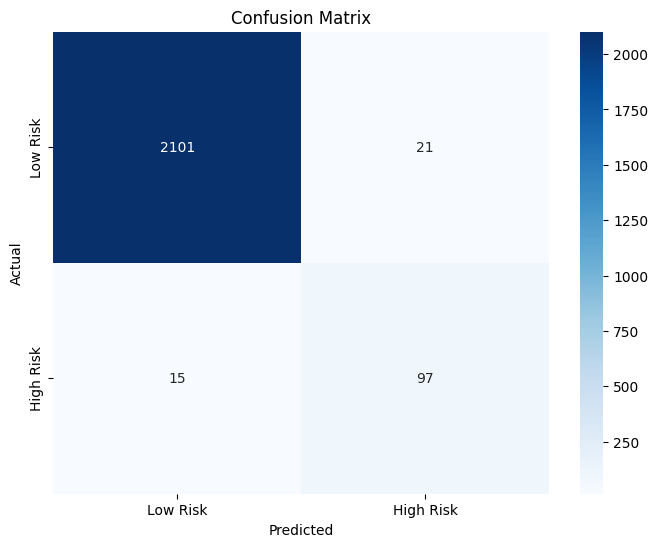

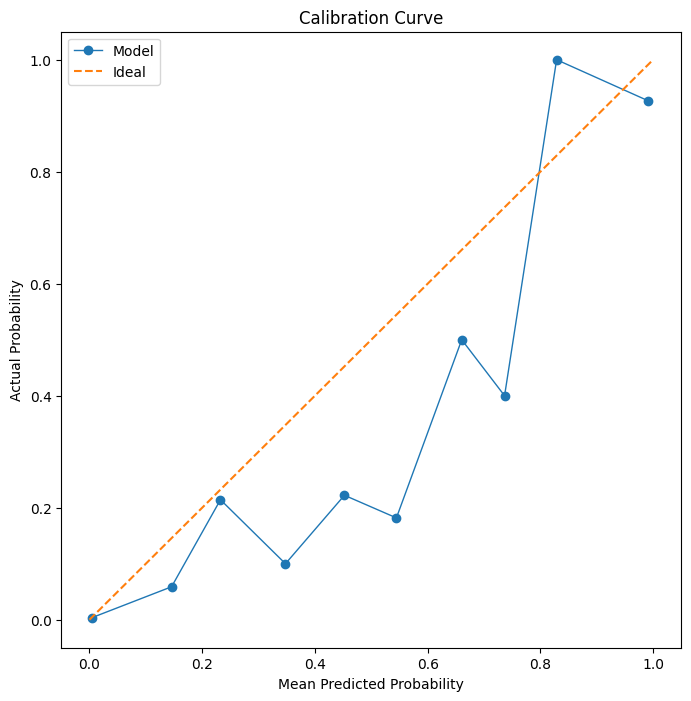

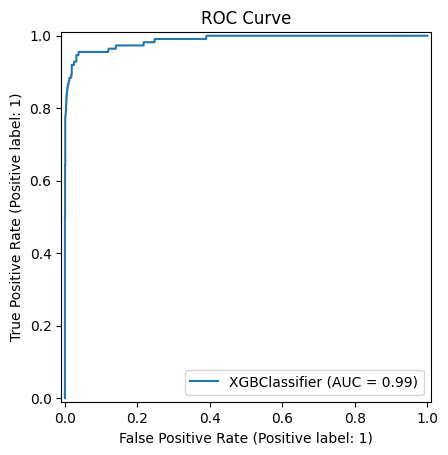

<Figure size 1000x600 with 0 Axes>

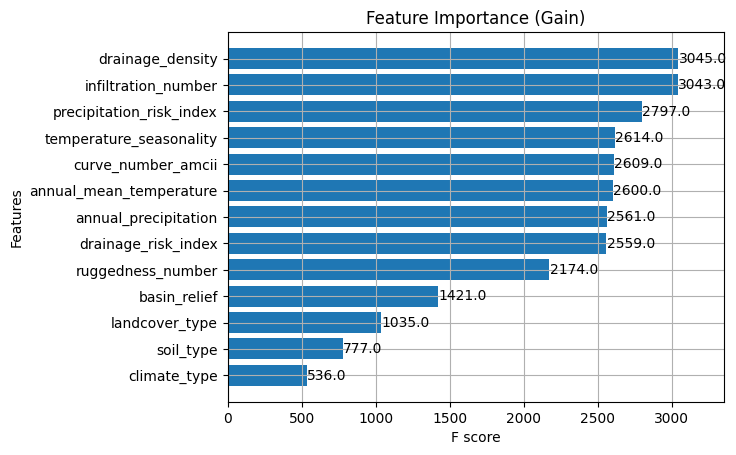

In [ ]:
# ======================
# 5. Enhanced Model Evaluation
# ======================
print("Evaluating model...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== Model Evaluation ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")

# Enhanced Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calibration Plot
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Actual Probability')
plt.legend()
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC Curve')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model, max_num_features=15, height=0.8)
plt.title('Feature Importance (Gain)')
plt.show()

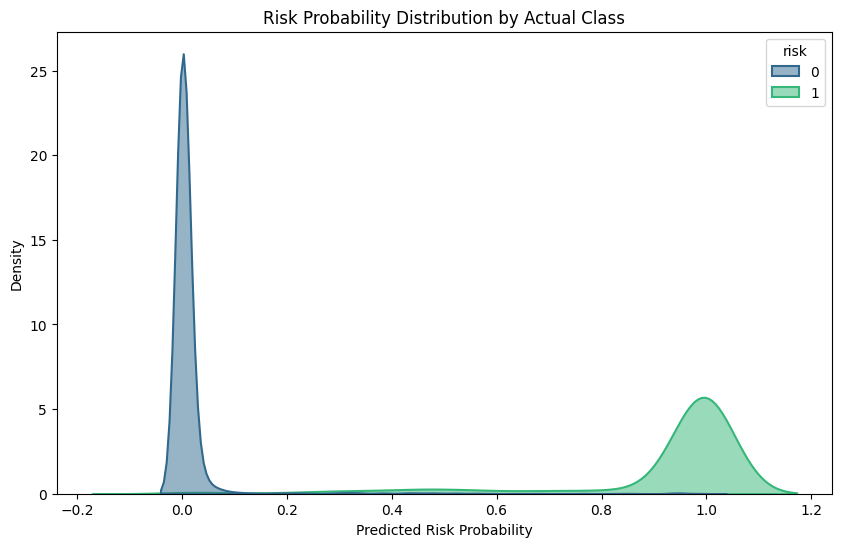

In [ ]:
# ======================
# 6. Advanced Visualization
# ======================
df['predicted_risk'] = best_model.predict_proba(X)[:, 1]
high_risk = df[df['predicted_risk'] > 0.7]

# Probability Distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df, x='predicted_risk', hue='risk',
    fill=True, common_norm=False, palette='viridis',
    alpha=0.5, linewidth=1.5
)
plt.title('Risk Probability Distribution by Actual Class')
plt.xlabel('Predicted Risk Probability')
plt.ylabel('Density')
plt.show()

# Temporal Analysis
if 'month_of_peak' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x=df['month_of_peak'],
        y=df['predicted_risk'],
        palette='coolwarm'
    )
    plt.title('Flood Risk Distribution by Month')
    plt.xlabel('Month of Peak Discharge')
    plt.ylabel('Predicted Risk Probability')
    plt.show()

# Interactive Map with Heatmap
def create_risk_map():
    risk_map = folium.Map(location=[20, 0], zoom_start=2, tiles='cartodbpositron')

    # Heatmap Layer
    heat_data = high_risk[['latitude', 'longitude', 'predicted_risk']].values.tolist()
    HeatMap(
        heat_data,
        radius=15,
        gradient={'0.4': 'blue', '0.6': 'lime', '0.7': 'yellow', '1': 'red'},
        blur=10
    ).add_to(risk_map)

    # Cluster Markers
    marker_cluster = MarkerCluster().add_to(risk_map)
    for _, row in tqdm(high_risk.iterrows(), total=len(high_risk), desc="Mapping risks"):
        popup_html = f"""
        <div style="width: 250px;">
            <h4 style="color:red; margin:2px;">🚨 Risk: {row['predicted_risk']:.1%}</h4>
            <b>Lat/Long:</b> {row['latitude']:.4f}, {row['longitude']:.4f}<br>
            <b>Precipitation:</b> {row['annual_precipitation']:.0f}mm<br>
            <b>Peak Discharge:</b> {row['annual_peak_discharge']:.1f}m³/s<br>
            <b>Drainage Density:</b> {row['drainage_density']:.2f}<br>
            <b>Soil Type:</b> {le_dict['soil_type'].inverse_transform([row['soil_type']])[0]}
        </div>
        """

        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup_html,
            icon=folium.Icon(color='red', icon='tint', prefix='fa'),
            tooltip=f"Risk: {row['predicted_risk']:.1%}"
        ).add_to(marker_cluster)

    folium.plugins.Fullscreen().add_to(risk_map)
    return risk_map

In [ ]:
# ======================
# 7. Comprehensive Report
# ======================
print("\n=== Validation Report ===")
print("Data Integrity Checks:")
print(f"- Removed {len(removed_features)} features during null handling")
print(f"- Maintained {len(selected_features)} selected features")
print(f"- Final class balance: {df['risk'].value_counts(normalize=True).to_dict()}")

print("\nModel Validation:")
print(f"- Best F1 Score: {grid_search.best_score_:.3f}")
print(f"- Test Set Recall: {recall_score(y_test, y_pred):.3f}")
print("- Calibration: Visual check of calibration curve")
print("- Feature Importance: Verified logical risk factors")

print("\n=== Flood Risk Prediction Report ===")
print(f"Total Locations Analyzed: {len(df)}")
print(f"High Risk Locations Identified: {len(high_risk)}")
print(f"Top Risk Factors:")
print("1. Precipitation Patterns (Annual & Seasonal)")
print("2. Drainage System Characteristics")
print("3. Basin Topography Features")
print("4. Land Cover & Soil Properties")

# Save predictions
print("\nSaving results...")
high_risk[['latitude', 'longitude', 'predicted_risk']].to_csv('high_risk_locations.csv', index=False)

# Display final map
risk_map = create_risk_map()
display(risk_map)


=== Validation Report ===
Data Integrity Checks:
- Removed 20 features during null handling
- Maintained 13 selected features
- Final class balance: {0: 0.9498567335243553, 1: 0.050143266475644696}

Model Validation:
- Best F1 Score: 0.988
- Test Set Recall: 0.866
- Calibration: Visual check of calibration curve
- Feature Importance: Verified logical risk factors

=== Flood Risk Prediction Report ===
Total Locations Analyzed: 11168
High Risk Locations Identified: 551
Top Risk Factors:
1. Precipitation Patterns (Annual & Seasonal)
2. Drainage System Characteristics
3. Basin Topography Features
4. Land Cover & Soil Properties

Saving results...


Mapping risks: 100%|██████████| 551/551 [00:00<00:00, 615.86it/s]


In [ ]:
# ======================
# 8. Model Export for Node.js (Add this new section)
# ======================
print("\n=== Exporting Model ===")

# 1. Save XGBoost model in JSON format
best_model.save_model('flood_model.json')

# 2. Save label encoders
joblib.dump(le_dict, 'label_encoders.pkl')

# 3. Save feature metadata
metadata = {
    'features': selected_features,
    'discharge_threshold': discharge_threshold,
    'risk_threshold': 0.7,
    'cat_cols': cat_cols,
    'version': '1.0.0'
}
joblib.dump(metadata, 'model_metadata.pkl')

# 4. Create zip archive
!zip -r model_package.zip flood_model.json label_encoders.pkl model_metadata.pkl

# 5. Download the zip file
files.download('model_package.zip')

print("Model package downloaded successfully!")


=== Exporting Model ===
  adding: flood_model.json (deflated 70%)
  adding: label_encoders.pkl (deflated 58%)
  adding: model_metadata.pkl (deflated 33%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model package downloaded successfully!
